# Color palette swapping
We can hide an image in another one by switching color palettes.
Let's try to hide `img_secret` in `img`:

In [1]:
using Images
using DitherPunk
using Clustering
using IndirectArrays
using TestImages

img = testimage("peppers")
img_secret = testimage("airplaneF16");

First we dither to eight colors:

┌ Warning: The clustering cost increased at iteration #49
└ @ Clustering ~/.julia/packages/Clustering/tt9vc/src/kmeans.jl:188
┌ Warning: The clustering cost increased at iteration #51
└ @ Clustering ~/.julia/packages/Clustering/tt9vc/src/kmeans.jl:188
┌ Warning: The clustering cost increased at iteration #53
└ @ Clustering ~/.julia/packages/Clustering/tt9vc/src/kmeans.jl:188
┌ Warning: The clustering cost increased at iteration #57
└ @ Clustering ~/.julia/packages/Clustering/tt9vc/src/kmeans.jl:188
┌ Warning: The clustering cost increased at iteration #59
└ @ Clustering ~/.julia/packages/Clustering/tt9vc/src/kmeans.jl:188
┌ Warning: The clustering cost increased at iteration #62
└ @ Clustering ~/.julia/packages/Clustering/tt9vc/src/kmeans.jl:188
┌ Warning: The clustering cost increased at iteration #63
└ @ Clustering ~/.julia/packages/Clustering/tt9vc/src/kmeans.jl:188
┌ Warning: The clustering cost increased at iteration #66
└ @ Clustering ~/.julia/packages/Clustering/tt9vc/src/kmeans

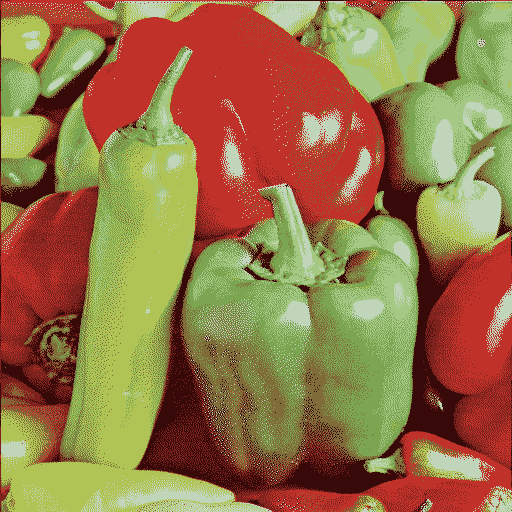

In [2]:
ncolors = 8
d = dither(img, FloydSteinberg(), ncolors)

┌ Warning: The clustering cost increased at iteration #42
└ @ Clustering ~/.julia/packages/Clustering/tt9vc/src/kmeans.jl:188
┌ Warning: The clustering cost increased at iteration #44
└ @ Clustering ~/.julia/packages/Clustering/tt9vc/src/kmeans.jl:188
┌ Warning: The clustering cost increased at iteration #48
└ @ Clustering ~/.julia/packages/Clustering/tt9vc/src/kmeans.jl:188
┌ Warning: The clustering cost increased at iteration #49
└ @ Clustering ~/.julia/packages/Clustering/tt9vc/src/kmeans.jl:188
┌ Warning: The clustering cost increased at iteration #51
└ @ Clustering ~/.julia/packages/Clustering/tt9vc/src/kmeans.jl:188


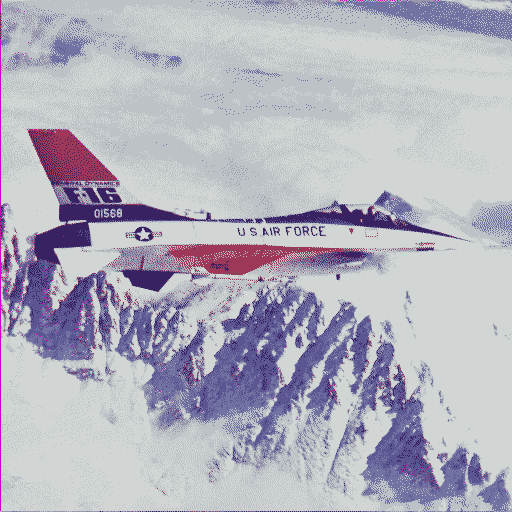

In [3]:
d_secret = dither(img_secret, FloydSteinberg(), ncolors)

Both of these images are IndirectArrays, which means they contain a color scheme

In [4]:
d.values

and a matrix of indices of type `UInt8` pointing to the color in the color scheme:

In [5]:
d.index

512×512 Matrix{UInt8}:
 0x04  0x06  0x04  0x01  0x04  0x04  …  0x01  0x01  0x04  0x01  0x01  0x04
 0x04  0x01  0x01  0x01  0x01  0x01     0x05  0x05  0x05  0x05  0x05  0x05
 0x04  0x01  0x01  0x01  0x05  0x01     0x05  0x08  0x08  0x08  0x08  0x08
 0x04  0x01  0x03  0x01  0x01  0x01     0x08  0x07  0x02  0x08  0x02  0x08
 0x04  0x01  0x03  0x01  0x03  0x01     0x07  0x02  0x07  0x02  0x07  0x02
 0x04  0x01  0x03  0x01  0x01  0x07  …  0x02  0x07  0x07  0x07  0x07  0x02
 0x04  0x01  0x01  0x07  0x01  0x01     0x07  0x07  0x02  0x07  0x08  0x02
 0x04  0x01  0x03  0x01  0x01  0x03     0x02  0x07  0x07  0x02  0x07  0x02
 0x04  0x01  0x01  0x03  0x01  0x03     0x07  0x07  0x02  0x02  0x02  0x02
 0x04  0x01  0x03  0x01  0x03  0x03     0x02  0x02  0x02  0x02  0x02  0x02
    ⋮                             ⋮  ⋱                             ⋮  
 0x04  0x08  0x03  0x07  0x03  0x08     0x05  0x05  0x07  0x05  0x05  0x05
 0x04  0x03  0x07  0x03  0x08  0x03     0x02  0x05  0x05  0x05  0x05  0x05
 0x04 

Since `typemax(UInt8)` is 255 and therefore larger than `ncolor^2`,
we can fit both images into a single index matrix by modifying the color schemes.
To recover the secret image, it is then only necessary to swap the new color schemes.

In [6]:
combineindex(a, b) = UInt8((a - 1) * ncolors + b)
function uncombineindex(c)
    b = (c - 1) % ncolors + 1
    a = Int((c - b) / ncolors) + 1
    return a, b
end

function combine_images(ia1::IndirectArray, ia2::IndirectArray)
    index = map(t -> combineindex(t...), zip(ia1.index, ia2.index))
    cs1 = similar(ia1.values, ncolors^2)
    cs2 = similar(ia2.values, ncolors^2)

    for i in 1:(ncolors^2)
        a, b = uncombineindex(i)
        cs1[i] = ia1.values[a]
        cs2[i] = ia2.values[b]
    end
    return index, cs1, cs2
end;

Let's test this on our dithered images

In [7]:
index, cs, cs_secret = combine_images(d, d_secret);

When using the color scheme `cs`, we recover the peppers:

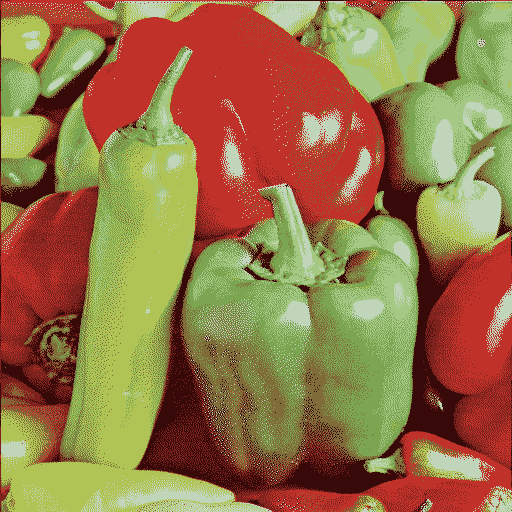

In [8]:
IndirectArray(index, cs)

However, when using the secret color scheme `cs_secret`, the F-16 airplane appears:

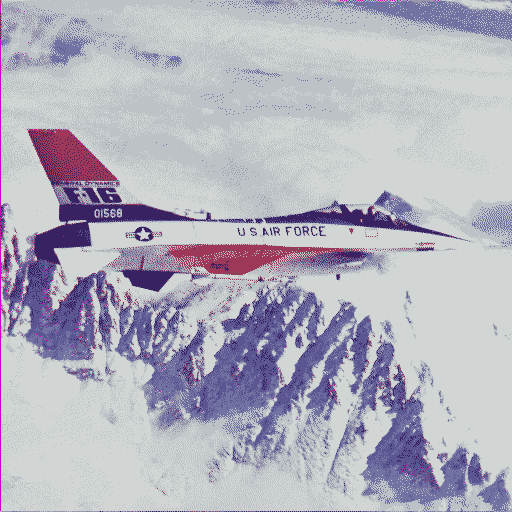

In [9]:
IndirectArray(index, cs_secret)

This certainly isn't a very secure way to hide an image in another one.
However, it can be useful when trying to fit multiple images on low memory microcontrollers.
As a matter of fact, this example was inspired by
[Mark Ferrari's GDC 2016 talk](https://youtu.be/aMcJ1Jvtef0?t=717)
where he used a similar technique for this very purpose.

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*